In [48]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# メインで分析するE-Mini S&P500先物データ読み込み

In [2]:
base_dir = 'data/e-mini-sp500-200530'
df_raw = pd.read_csv(f'{base_dir}/e-mini-sp500-daily.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5729 non-null   object 
 1   Time    5729 non-null   object 
 2   Open    5729 non-null   float64
 3   High    5729 non-null   float64
 4   Low     5729 non-null   float64
 5   Close   5729 non-null   float64
 6   Vol     5729 non-null   int64  
 7   OI      5729 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 358.2+ KB


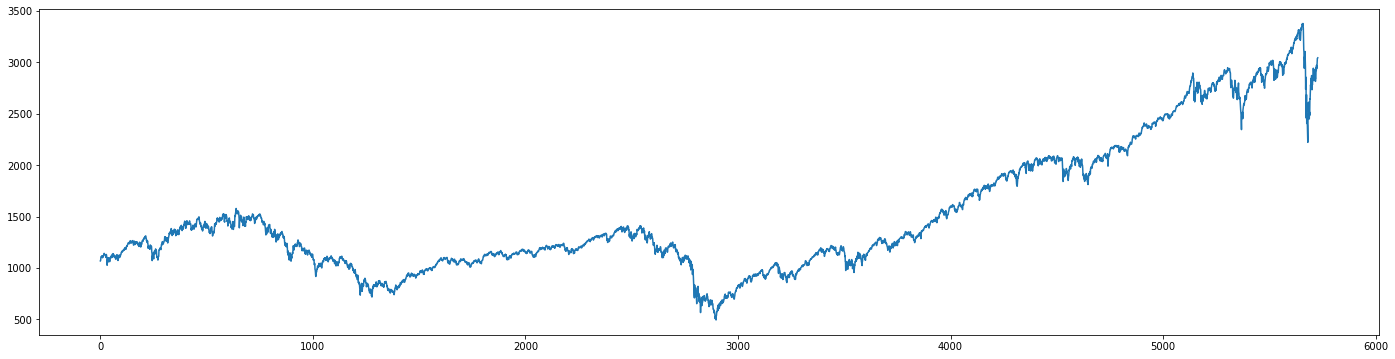

In [3]:
plt.figure(figsize=(24, 6))
plt.plot(df_raw['Close'])

# datetime indexに変換

In [4]:
df = df_raw.copy()
# DateTime列を追加
df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
df = df.set_index('datetime', drop=True)
df = df.drop(columns=['Date', 'Time'])
df.head(1)

,Open,High,Low,Close,Vol,OI
datetime,,,,,,
1997-09-11 17:00:00,1071.25,1082.25,1062.75,1068.5,11825,2909


# まずは対数変換

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


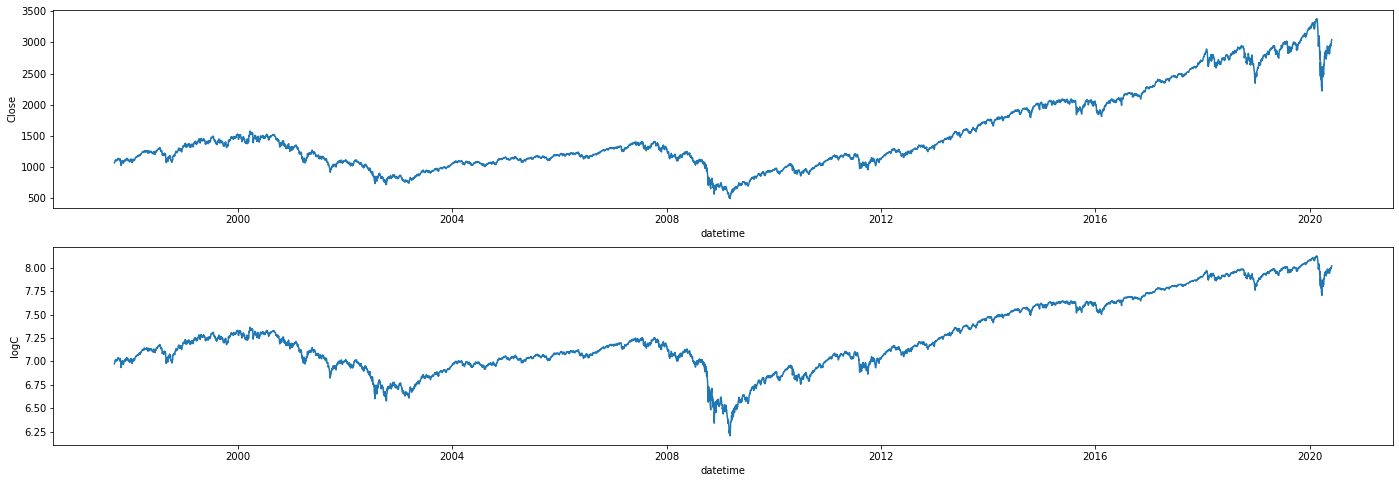

In [5]:
df['logO'] = np.log(df['Open'])
df['logH'] = np.log(df['High'])
df['logL'] = np.log(df['Low'])
df['logC'] = np.log(df['Close'])
df['logV'] = np.log(df['Vol'])
df['logOI'] = np.log(df['OI'])

fig, ax = plt.subplots(2, 1, figsize=(24, 8))
sns.lineplot(df.index, df['Close'], ax=ax[0])
sns.lineplot(df.index, df['logC'], ax=ax[1])

# 1時刻の階差をとる（これは対数差収益率と言われる）

In [6]:
diff_df = df.diff()
diff_df

,Open,High,Low,Close,Vol,OI,logO,logH,logL,logC,logV,logOI
datetime,,,,,,,,,,,,
1997-09-11 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12 17:00:00,-0.75,6.75,3.25,2.75,-2066.0,1150.0,-0.000700,0.006218,0.003053,0.002570,-0.192026,0.333127
1997-09-15 17:00:00,15.50,3.25,15.50,12.50,-1208.0,-241.0,0.014375,0.002980,0.014436,0.011601,-0.132142,-0.061210
1997-09-16 17:00:00,-2.25,20.25,1.25,24.75,3198.0,1496.0,-0.002074,0.018370,0.001155,0.022581,0.317720,0.330618
1997-09-17 17:00:00,24.75,2.50,21.25,0.00,-900.0,202.0,0.022581,0.002245,0.019436,0.000000,-0.079695,0.037308
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22 17:00:00,-35.50,-16.00,-29.25,16.00,-230962.0,4668.0,-0.012016,-0.005395,-0.010023,0.005433,-0.155033,0.001487
2020-05-26 17:00:00,11.75,62.25,43.75,41.50,419978.0,-19691.0,0.003993,0.020830,0.014954,0.013956,0.266155,-0.006288
2020-05-27 17:00:00,45.50,19.75,18.00,41.00,312091.0,20185.0,0.015314,0.006519,0.006088,0.013599,0.160119,0.006445


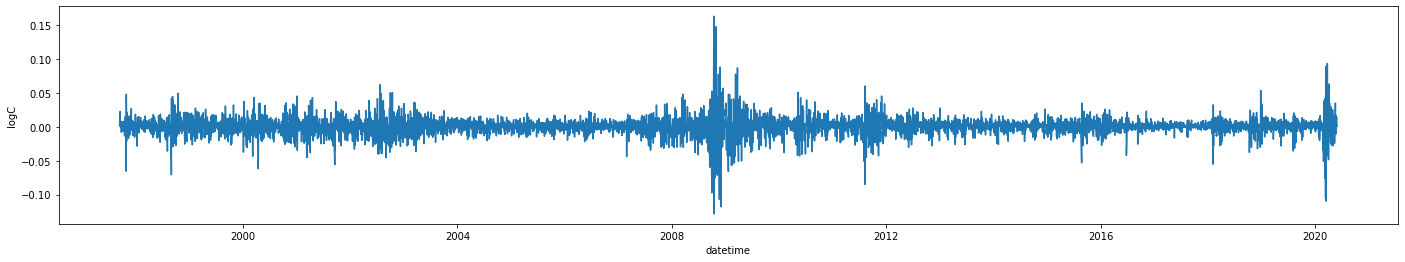

In [7]:
plt.figure(figsize=(24,4))
sns.lineplot(diff_df.index, diff_df['logC'])

# 見やすさのため100倍した対数差収益率

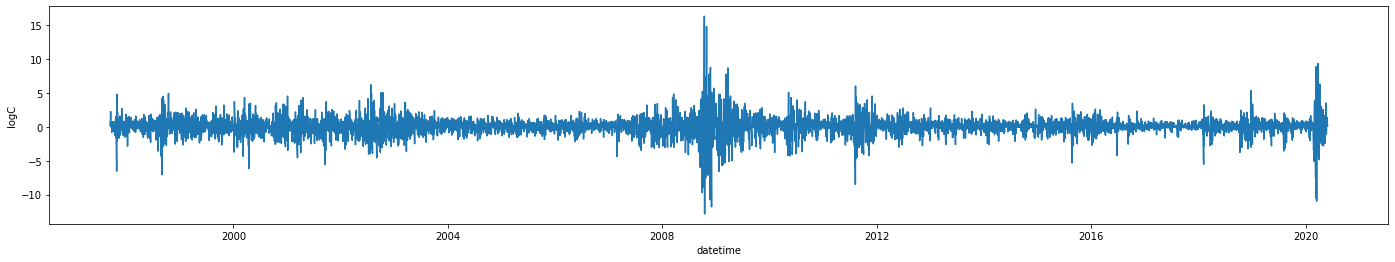

In [8]:
for col in ['logO', 'logH', 'logL', 'logC', 'logV', 'logOI']:
    diff_df[col] = diff_df[col] * 100
plt.figure(figsize=(24, 4))
sns.lineplot(diff_df.index, diff_df['logC'])

# ここから期間を絞る
- 標本数を増やすために観測期間を伸ばした場合、市場環境の変化などの要因から同一条件のもとでのデータであるとの前提を置きにくくなる。
- したがって、ここでは2019年の1年間のデータに絞る

In [9]:
df2019 = diff_df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)]
df2019.head(1)

,Open,High,Low,Close,Vol,OI,logO,logH,logL,logC,logV,logOI
datetime,,,,,,,,,,,,
2019-01-02 17:00:00,12.5,8.25,-30.5,5.75,555103.0,12103.0,0.499103,0.327397,-1.234709,0.229004,33.103716,0.452061


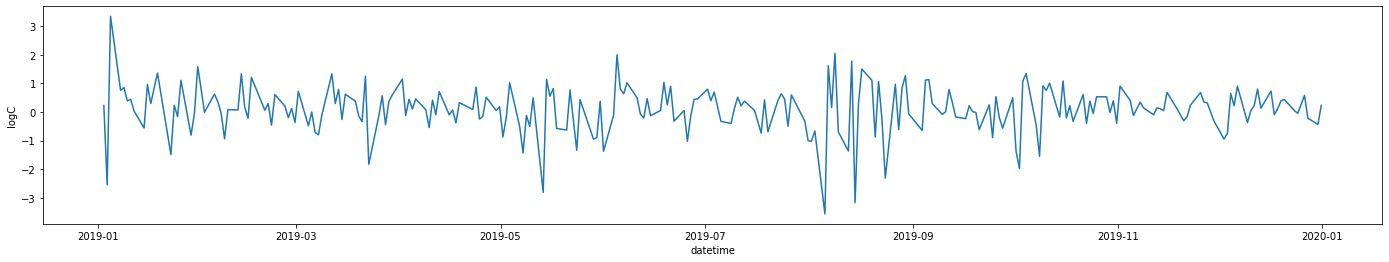

In [10]:
# 対数差収益率
plt.figure(figsize=(24, 4))
sns.lineplot(df2019.index, df2019['logC'])

# 比較用に金先物データも読み込む

In [11]:
dfg = pd.read_csv(f'data/gold-200626/gold-daily.csv')

# DateTime列を追加
dfg['datetime'] = (dfg['Date'] + '-' + dfg['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
dfg = dfg.set_index('datetime', drop=True)
dfg = dfg.drop(columns=['Date', 'Time'])

# 対数変換
dfg['logO'] = np.log(dfg['Open'])
dfg['logH'] = np.log(dfg['High'])
dfg['logL'] = np.log(dfg['Low'])
dfg['logC'] = np.log(dfg['Close'])
dfg['logV'] = np.log(dfg['Vol'])
dfg['logOI'] = np.log(dfg['OI'])

# 対数差収益率（100倍）
diff_dfg = dfg.diff()
for col in ['logO', 'logH', 'logL', 'logC', 'logV', 'logOI']:
    diff_dfg[col] = diff_dfg[col] * 100

# 2019年の1年間データ
dfg2019 = diff_dfg[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)]
dfg2019.head(1)

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Open,High,Low,Close,Vol,OI,logO,logH,logL,logC,logV,logOI
datetime,,,,,,,,,,,,
2019-01-02 17:00:00,2.0,4.5,0.9,2.8,122076.0,-2441.0,0.147135,0.3299,0.066399,0.206186,73.133738,-0.761741


# 金先物の2019年の対数差収益率

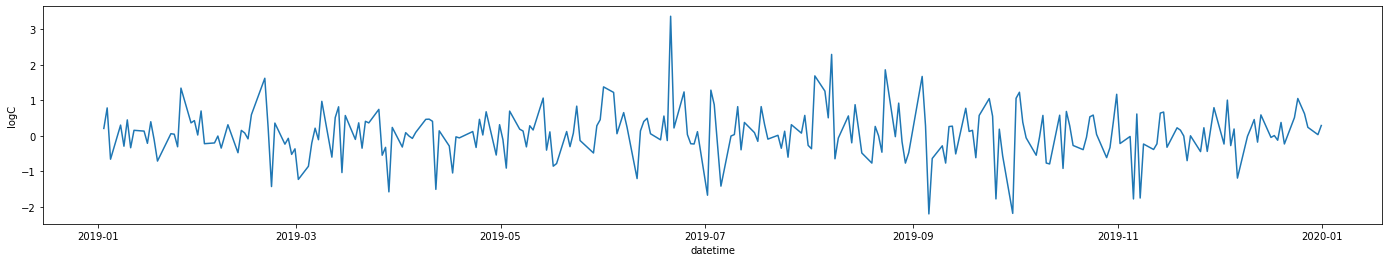

In [12]:
plt.figure(figsize=(24, 4))
sns.lineplot(dfg2019.index, dfg2019['logC'])

# 基本的な統計情報
- 測定期間を通した平均
- 測定期間を通した標準偏差（ヒストリカルボラティリティ）

In [13]:
print(f"S&Pの平均（％）：{df2019['logC'].mean()}")
print(f"S&Pの標準偏差：{df2019['logC'].std()}")

print(f"金の平均（％）：{dfg2019['logC'].mean()}")
print(f"金の標準偏差：{dfg2019['logC'].std()}")

S&Pの平均（％）：0.09913416429363779
S&Pの標準偏差：0.8203474187780669
金の平均（％）：0.055539932190683414
金の標準偏差：0.6995382599016865


# ヒストグラム

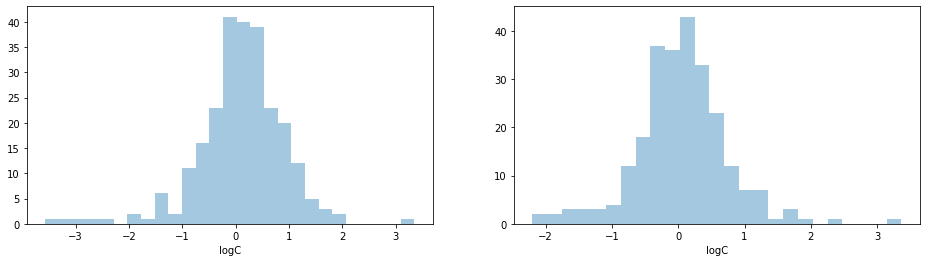

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df2019['logC'], ax=ax[0], kde=False)
sns.distplot(dfg2019['logC'], ax=ax[1], kde=False)

# S&Pと金を比較しやすいようなデータを作る

In [15]:
dfsg = pd.DataFrame({'spC': df2019['logC'], 'goldC': dfg2019['logC']})

# 相関を見る（散布図）

S&Pと金の相関係数：-0.25098560573767936


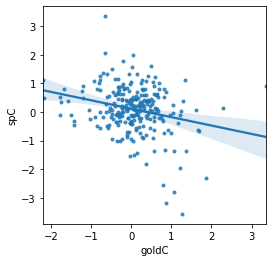

In [46]:
plt.figure(figsize=(4,4))
sns.regplot('goldC', 'spC', data=dfsg, marker='.')

# 相関係数
print(f"S&Pと金の相関係数：{dfsg.corr().loc['spC', 'goldC']}")

# データの性質を確認

## データの正規性を正規Q-Qプロットで確認

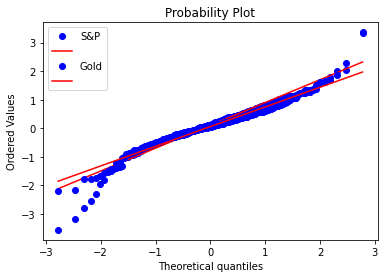

In [38]:
"""
平均から大きく離れると正規分布から外れていくようだ
"""

stats.probplot(dfsg['spC'], dist="norm", plot=plt)
stats.probplot(dfsg['goldC'], dist="norm", plot=plt)
plt.legend(['S&P','', 'Gold',''])
plt.show()

## データが正規分布に従うかどうかを仮説検定
Shapiro-Wilkの検定
- 帰無仮説：データが正規分布に従う

In [37]:
# S&Pのデータが正規分布に従っているか検定（帰無仮説は「従っている」）
"""
有意水準は「現場で使える時系列データ分析（chapter2-3）」に従って10%とする
S&P先物については、p=2.55e-08 << 0.1 より正規分布に従うとは仮定できない
金先物についても、p=3.69e-06 << 0.1 より正規分布に従うとは仮定できない
"""

W_sp, p_sp = stats.shapiro(dfsg['spC'])
print(f"S&P500先物データのp値：{p_sp}")

W_gold, p_gold = stats.shapiro(dfsg['goldC'])
print(f"金先物データのp値：{p_gold}")

S&P500先物データのp値：2.559504430621473e-08
金先物データのp値：3.690074436235591e-06


## 各サンプルが独立（i.i.d.）かどうかを検証
- ここでは簡略化のため、平均以上であれば＋、平均未満であればーとして2値化する
- その上で「連の検定」で＋とーの並び方に規則性がないことを検定する
- 帰無仮説：＋とーの並び方に規則性はない

pythonでは、statsmodelsからrunstest_1sampという関数が提供されている。

https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.runs.runstest_1samp.html?highlight=runs

これを使う場合は、実数値列を引数に渡せば、内部で2値化してくれるので自分でやる必要はない。2値化のとき、`cutoff`という引数に'mean'または'median'を指定することでどちらを基準にするか選択できる。デフォルトは'mean'。

In [47]:
"""
有意水準は「現場で使える時系列データ分析（chapter2-3）」に従って10%とする
S&P先物については、p=0.197 > 0.1 より+/-の並び方に規則性は無いことを棄却できない（独立だと仮定して良い）
--> df4000を使った場合はp=0.049となったから長期で見ればこちらもやはり独立性は仮定できなさそうだ
金先物については、p=0.076 < 0.1 より帰無仮説は棄却される（独立だと仮定できない）
"""
z_sp, p_sp = runs.runstest_1samp(dfsg['spC'])
print(f"S&P500先物データのp値：{p_sp}")
z_gold, p_gold = runs.runstest_1samp(dfsg['goldC'])
print(f"金先物データのp値：{p_gold}")

S&P500先物データのp値：0.19722949293502512
金先物データのp値：0.07698201286533209
